In [44]:
import casadi as ca
import SimpleOpt as so
import numpy as np
import scipy as sp
import sys
import matplotlib.pyplot as plt
sys.path.append('/Users/jeremy/git/python-control/')
import control as ctrl


# go Variance 1 ran a discretized system
# go Variance 2 will now run a continuous system, and i should be able to check that the
# continous

def trapInt(t,inVec):
  sumval = 0.
  for ii in range(0,inVec.shape[1]-1):
      sumval = sumval + (inVec[ii]+inVec[ii+1])/2.0 * (t[ii+1]-t[ii])
  return sumval
  
# Constants
p_0 = 0    # Initial position
v_0 = 0    # Initial velocity
p_f = 1    # Final position
v_f = 0    # Final velocity (at step nm)

# 1D 
n     = 50 # total of 100 supports
nm    = n-1  # finish & hold at index nm
dtau  = 1/n # dimensionless dtau
Bs    = 0   # damping
M     = 1   # Mass
kVar = 0.5

opti = ca.Opti()
p = opti.variable(n,1)
v = opti.variable(n,1) 
F = opti.variable(n,1) 
Fdot = opti.variable(n,1) 
Fddot = opti.variable(n-1,1) 
V11 = opti.variable(n-1,1) 
Ek = opti.variable(n-1,1) 
slackFddp = opti.variable(n-1,1) 
slackFddn = opti.variable(n-1,1) 
posPowJ = opti.variable(n-1,1) 
slackPosPowJ = opti.variable(n-1,1) 
T = opti.variable(1,1)

  # Start with continuous-time state space, then discrete time
A = np.array([[0, 1, 0, 0], [0, -Bs/M, 1/M, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
# position, velocity, F, Fdot
B = np.array([[0], [0], [0], [1]])
C = np.array([1, 0, 0, 0])
D = [0]



In [45]:
# 0. SYSTEM EQUATIONS. 
sseye = ctrl.ss(A,B,C,D)
ssdeye = ctrl.c2d(sseye,dtau)
#sseye = ctrl.ss(A, B, C, D)
#ssdeye = ctrl.c2d(sseye, Δt)[1,1] # exp(A Δt)


def matpow(inmat,n):
  inmatp = inmat
  for j in range(0,n-1):
    inmatp=inmatp @ inmat
  return inmatp

### A note on Converting Loops between languages
first question: is the iterate used (primarily) for math, or for indexing?  
if indexing:  
- convert the for-loop from matlab/julia[m,n] to python[m-1,n).  

if math:  
- then convert the looprange from matlab/julia[m,n] to python[m,n+1) . 
- and manually adjust any indices by -1.  

In [46]:
#0.5 VARIANCE calculation, discrete. 
# this should compare well with variance from continuous calculation. 
V11expr = ca.MX.zeros(n-1,n-1)

# these loops are for math. 
for myt in range(2,n+1): #convert the loop for math
  for i in range(1,myt-1): #convert the loop for math
    AB = matpow(ssdeye.A, myt-1-i) @ (ssdeye.B)
    ABBA = AB @ AB.T
    V11expr[myt-1-1,i-1] = ABBA[0,0]*F[i-1]*F[i-1] #manually adjust the indices
    

In [47]:
# 0 VARIANCE, continuous.
Sigma_j   = ca.MX.zeros(sseye.A.shape[0],sseye.A.shape[1])
#Sigma_js  = ca.MX.zeros(sseye.A.shape[0],sseye.A.shape[1],n)
Sigma_jp  = ca.MX.zeros(n,1)
for j in np.arange(0,n-1):
  #dΣⱼ = sseye.A * Σⱼ + Σⱼ' * sseye.A' + sseye.B*u[j]*u[j]*sseye.B'
  dSigma_j        = sseye.A @ Sigma_j + Sigma_j.T @ sseye.A.T + \
                    (F[j] * F[j] * kVar) * (sseye.B @ sseye.B.T) 
  Sigma_j         = T*(Sigma_j + (dSigma_j) * dtau)       #Euler
  #Sigma_js[:,:,j] = Sigma_j
  Sigma_jp[j+1]   = dSigma_j[0,0] + Sigma_jp[j]           #sigma position over time. 

In [48]:
# 1. INITIAL and FINAL conditions
opti.subject_to(p[0]  == 0 )
opti.subject_to(v[0]  == 0 )
opti.subject_to(p[nm] == p_f)
opti.subject_to(v[nm] == 0 )
opti.subject_to(F[0]  == 0 )
opti.subject_to(Fdot[0]  == 0 )
opti.subject_to(F[nm]  == 0 )
opti.subject_to(Fdot[nm]  == 0 )



In [49]:
# 2. HOLD period
for j in np.arange(nm,n): # julia nm+1:n # during hold period, keep velocity zero
    opti.subject_to(v[j] == 0)

In [50]:

# 3. SLACK vars for fdotdot
for j in np.arange(0,n-1): # during hold period, keep velocity zero
  opti.subject_to(slackFddp[j] >=Fddot[j])
  opti.subject_to(slackFddp[j] >=0)
  opti.subject_to(slackFddn[j] <=Fddot[j])
  opti.subject_to(slackFddn[j] <=0)

In [51]:
# 4. DYNAMICS, as state-space linear system
for j in np.arange(1,n): #julia 2:n
    opti.subject_to(p[j] == p[j-1] + T*dtau*v[j-1])
    opti.subject_to(v[j] == v[j-1] + T*dtau*(-Bs*v[j-1] + F[j-1])) #EOM
    opti.subject_to(F[j] == F[j-1] + T*dtau*Fdot[j-1])
    opti.subject_to(Fdot[j] == Fdot[j-1] + T*dtau*Fddot[j-1])

In [52]:
#6. OBJECTIVE: ENERGY need to be set here. 
for j in np.arange(0,n-1):#julia j in 1:n-1
  opti.subject_to(posPowJ[j]  == v[j] * F[j])
  opti.subject_to(slackPosPowJ[j] >=posPowJ[j])
  opti.subject_to(slackPosPowJ[j] >=0)

In [53]:
#7. OBJECTIVE: VARIANCE, discrete
for j in np.arange(0,n-1):#julia j in 1:n-1
  opti.subject_to(V11[j] == kVar * ca.sum2(V11expr[j,1:j]))   # setting covariance11

In [54]:
#7. Objectives
tvec    = np.linspace(0,1,num=n)*T

kFR     = 1e-1 #bells for 1e-1, together with T = 1, work = 8
objFrJ  = kFR * trapInt(tvec[0:-1], -slackFddn + slackFddp)*T

kPosWorkW   = 4.2
objPosWorkJ = kPosWorkW * trapInt(tvec[1:-1],slackPosPowJ)*T

kT       = 1
objTimeJ = kT*T

varianceHold = ca.sum1(V11[nm:-1])

#sigma constraint
opti.subject_to(Sigma_jp[-1] <= 5)

#minimize Fdot squared over movement period
opti.minimize(objFrJ + objPosWorkJ + objTimeJ)
# opti.minimize(ca.sumsqr(Fddot))




This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2117
Number of nonzeros in inequality constraint Jacobian.:      485
Number of nonzeros in Lagrangian Hessian.............:      294

Total number of variables............................:      495
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      303
Total number of inequality constraints...............:      295
        inequality constraints with only lower bounds:       98
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      197



Exception: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0

Number of Iterations....: 0

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   1.0000000000000000e+00    1.0000000000000000e+00
Constraint violation....:   1.0000000000000000e+00    1.0000000000000000e+00
Complementarity.........:   5.0000000499999997e+00    5.0000000499999997e+00
Overall NLP error.......:   5.0000000499999997e+00    5.0000000499999997e+00


Number of objective function evaluations             = 1
Number of objective gradient evaluations             = 1
Number of equality constraint evaluations            = 1
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 1
Number o

intermediate_callback: Error in Function::operator() for 'InternalOptiCallback' [InternalOptiCallback] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for InternalOptiCallback:
.../casadi/build/swig/casadiPYTHON_wrap.cxx:3799: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.


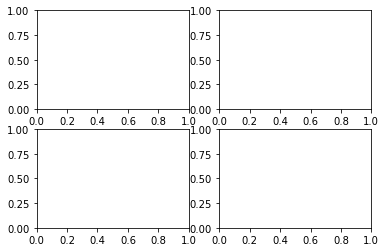

In [55]:
maxIter = 1000
pOpt = {"expand":True}
sOpt = {"max_iter"        : maxIter,
        "constr_viol_tol" : 1e-2,
        "dual_inf_tol"    : 1e-2}
opti.solver('ipopt',pOpt,sOpt)
f,ax = plt.subplots(2,2)
def callbackPlots(i):
    ax[0,0].plot(tvec,opti.debug.value(p))
    ax[0,1].plot(tvec,opti.debug.value(v),color=(1,.8-.8*i/(maxIter),1))
    #ax[1,0].plot(tvec[0:-1],opti.debug.value(V11),color=(1,.8-.8*i/(maxIter),1))
    ax[1,0].plot(tvec,opti.debug.value(Sigma_jp),color=(1,.8-.8*i/(maxIter),1))
    ax[1,0].plot(tvec[0:-1],opti.debug.value(V11),color=(1,.8-.8*i/(maxIter),1))
    ax[1,1].plot(tvec[0:-1],opti.debug.value(Fddot),color=(1,.8-.8*i/(maxIter),1))
opti.callback(callbackPlots)

try:
      sol = opti.solve()
except:
  print("did not find solution")

# p_opt = opti.value(p)
# fig, ax = plt.subplots()
# p1 = plt.plot(tvec, p)
# p2 = plot(tvec, [res.v for res in eyefrresults], xlabel="t", ylabel="velocity")
# p3 = plot(tvec, [res.F for res in eyefrresults], xlabel="t", ylabel="F")
# p4 = plot(tvec[1:n-1], [res.Fddot[1:n-1] for res in eyefrresults], xlabel="t", ylabel="Fddot")
# plot(p1,p2,p3,p4,layout=(2,2),label="")



In [ ]:
fig,ax = plt.subplots()
k = max(opti.debug.value(Sigma_jp))/max(opti.debug.value(V11))
plt.plot(tvec[0:-1],opti.debug.value(V11)*k,color=(1,.8-.8*i/(maxIter),1))
plt.plot(tvec[0:-1],opti.debug.value(Sigma_jp[1:]))

max(opti.debug.value(opti.debug.value(V11)))

In [ ]:
max(opti.debug.value(Sigma_jp))/max(opti.debug.value(V11))